# Pandas

This notebook covers a _lot_, go through it carefully and _read_ the code. Then work on _understanding_ it. Then apply it to your data set. Then once you've done that, you'll probably _actually_ understand it.

Messing about with the [NSW Penalty data](http://www.osr.nsw.gov.au/sites/default/files/file_manager/penalty_data_set_0.csv)

`imports`, you've seen this before!

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shapely
import fiona
import geopandas as gp
from shapely.geometry import Polygon
# import matplotlib.colors as mcolors

Koalas are commonly admitted for treatment and/or rehabilitation for the following reasons:

- chlamydial-related diseases. Chlamydia are bacteria which cause chronic infection including conjunctivitis, cystitis, infertility and kidney failure
- traumatic injuries caused by cars and dogs
- orphaned joeys (baby koalas).

Statistics are collected from all koalas and are entered onto a specifically designed koala database which now contains over 50,000 records. This information is used by the department to produce maps and reports which guide koala management decisions.

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)


In [3]:
saved_style_state = matplotlib.rcParams.copy() #give us a style state to go back to
colors = plt.cm.Spectral(np.linspace(0, 1, 25))

In [4]:

fp = 'maps/QLD_LOCALITY_POLYGON_shp.shp'
QLD = gp.GeoDataFrame.from_file(fp)
QLD.drop(["QLD_LOCA_1", "QLD_LOCA_3", "QLD_LOCA_4", "QLD_LOCA_6", "DT_RETIRE", "QLD_LOCA_7", "QLD_LOCA_5"], axis=1, inplace=True)

QLD.head()

,LC_PLY_PID,DT_CREATE,LOC_PID,QLD_LOCALI,QLD_LOCA_2,geometry
0,67839,2018-09-13,QLD1991,2016-08-10,MOUNT BERRYMAN,"POLYGON ((152.30132 -27.75523, 152.30122 -27.7..."
1,64808,2017-06-14,QLD2092,2017-08-10,MOUNTAIN CREEK,"POLYGON ((153.10559 -26.71514, 153.10323 -26.7..."
2,64939,2017-06-14,QLD1803,2017-08-10,MARCOOLA,"POLYGON ((153.09112 -26.61160, 153.09065 -26.6..."
3,67905,2018-09-13,QLD744,2018-05-09,COVERTY,"POLYGON ((151.44572 -26.33205, 151.44550 -26.3..."
4,63067,2016-06-29,QLD3331,2018-08-07,BOUNTIFUL ISLANDS,"POLYGON ((139.84126 -16.70989, 139.84113 -16.7..."


In [5]:
if os.path.isfile("koalabase.csv"):
    filepath = "koalabase.csv"
    print("loading from file")

koala_data = pd.read_csv(filepath)
print("done")

loading from file
done


/Users/joelnorman/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26,27,29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
date = koala_data["Call Date "].str.split("/", expand = True)
koala_data["Year"]= date[2]
koala_data["Month"]= date[1]
koala_data.drop(["Animal Record No. ", "Release LNG", "Release LAT", "Wasted"], axis=1, inplace=True)
koala_data['Month'] = koala_data['Month'].replace({'01':'Jan', '02':'Feb','03':'Mar', '04':'Apr','05':'May', '06':'Jun','07':'Jul', '08':'Aug','09':'Sep', '10':'Oct','11':'Nov', '12':'Dec'})

koala_data.head()



,Call Date,Animal Name,LATITUDE,LONGITUDE,Adult Fate Other,Adult Size,Adult Gender,Adult Situation,Adult Situation Other,Young Present,...,Vehicle Hit,Road Speed Limit (Km),Fall,Injury Other,Status Other,Release Date,Release Suburb,Release Post Code,Year,Month
0,4/07/1996,SIGHTING,-27.182496,153.016159,NaN,Adult (More than 4kg),Unknown,In tree,NaN,False,...,False,NaN,False,NaN,NaN,NaN,NaN,NaN,1996,Jul
1,5/07/1996,SIGHTING,-27.638595,153.156763,NaN,Unknown (not recorded),Unknown,In tree,NaN,False,...,False,NaN,False,NaN,NaN,NaN,NaN,NaN,1996,Jul
2,1/01/1997,SIGHTING,NaN,NaN,NaN,Adult (More than 4kg),Unknown,In tree,NaN,False,...,False,NaN,False,NaN,NaN,NaN,NaN,NaN,1997,Jan
3,1/01/1997,PHILLY,-27.544270,153.224509,NaN,Sub-Adult (2-4kg),Male,In tree,NaN,False,...,False,NaN,False,NaN,NaN,9/01/1997,Alexandra Hills,4161.0,1997,Jan
4,1/01/1997,CARRIE,-27.516611,153.223217,NaN,Sub-Adult (2-4kg),Female,In tree,NaN,False,...,False,NaN,False,NaN,NaN,13/01/1997,Alexandra Hills,4161.0,1997,Jan


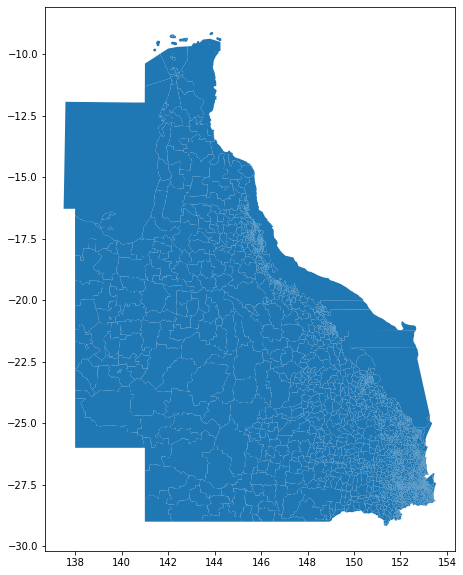

In [7]:
QLD.plot()

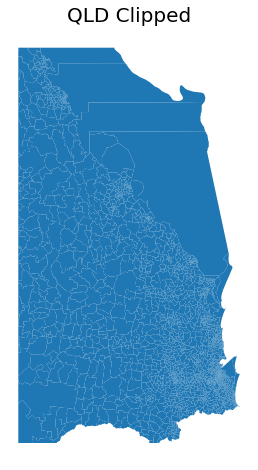

In [8]:
# Create a custom polygon
polygon = Polygon([(148, -29), (148, -20), (154, -20), (154, -29), (148, -29)])
poly_gdf = gp.GeoDataFrame([1], geometry=[polygon], crs=QLD.crs)

QLD_clipped = gp.clip(QLD, polygon)

# Plot the clipped data
# The plot below shows the results of the clip function applied to the world
fig, ax = plt.subplots(figsize=(12, 8))
QLD_clipped.plot(ax=ax)
# QLD.boundary.plot(ax=ax) (shows the rest of QLD)
# poly_gdf.boundary.plot(ax=ax, color="red")
ax.set_title("QLD Clipped", fontsize=20)
ax.set_axis_off()
plt.show()

In [9]:
gdf = gp.GeoDataFrame(koala_data, geometry=gp.points_from_xy(koala_data.LONGITUDE, koala_data.LATITUDE))
poly_gdf = gp.GeoDataFrame([1], geometry=[polygon], crs=gdf.crs)
gdf_clipped = gp.clip(gdf, polygon)


In [12]:
situ = koala_data['Adult Situation']

Index= situ[situ['Adult Situation']=='In tree'].index

# now use df.loc to set values only to those rows
situ.loc[index,'Adult Situation'] = 1

situ


KeyError: 'Adult Situation'

ValueError: 'c' argument must be a mpl color, a sequence of mpl colors or a sequence of numbers, not Adult Situation.

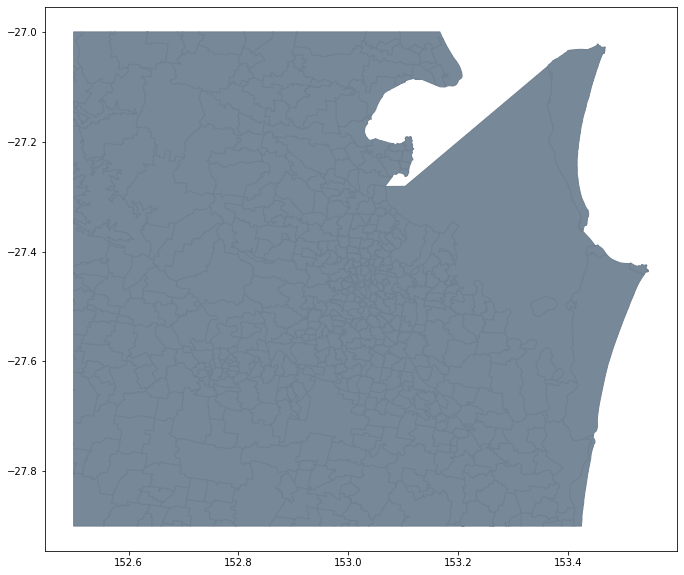

In [204]:


fig, ax = plt.subplots()
ax.set_aspect('equal')

QLD_clipped.plot(ax=ax, color = 'lightslategrey',edgecolor='slategray')
gdf_clipped.plot(ax=ax, color='black', marker=".", markersize=25)
ax.set_title("Locations of Koala Reports in Queensland", fontsize=20)
plt.xlabel('Latitude', fontsize=15)
plt.ylabel('Longitude', fontsize=15)

In [79]:
koala_data.columns

Index(['Call Date ', 'Animal Name', 'LATITUDE', 'LONGITUDE',
       'Adult Fate Other', 'Adult Size', 'Adult Gender', 'Adult Situation',
       'Adult Situation Other', 'Young Present', 'Adult Fate',
       'Young Fate Other', 'Young Fate', 'Koala Suburb', 'Koala Post Code',
       'Koala LGA', 'Sick', 'Injured', 'Caused By Dog', 'Orphaned',
       'Under Threat', 'Dead', 'Conjunctivitis', 'Cystitis', 'Sick Other',
       'Vehicle Hit', 'Road Speed Limit (Km)', 'Fall', 'Injury Other',
       'Status Other', 'Release Date', 'Release Suburb', 'Release Post Code',
       'Year', 'Month', 'geometry'],
      dtype='object')

In [80]:
row_one = koala_data.iloc[1]
row_one

Call Date                                      5/07/1996
Animal Name                                     SIGHTING
LATITUDE                                        -27.6386
LONGITUDE                                        153.157
Adult Fate Other                                     NaN
Adult Size                        Unknown (not recorded)
Adult Gender                                     Unknown
Adult Situation                                  In tree
Adult Situation Other                                NaN
Young Present                                      False
Adult Fate                                         Other
Young Fate Other                                     NaN
Young Fate                                         Other
Koala Suburb                                  Daisy Hill
Koala Post Code                                     4127
Koala LGA                             Logan City Council
Sick                                               False
Injured                        

1996       2
2017      39
2015     136
2014     430
2013     520
2016     942
2012    1020
1997    1862
1998    1890
1999    1944
2011    2055
2006    2207
2007    2236
2003    2294
2001    2350
2008    2487
2005    2500
2002    2517
2004    2719
2000    2939
2010    3320
2009    3496
Name: Year, dtype: int64


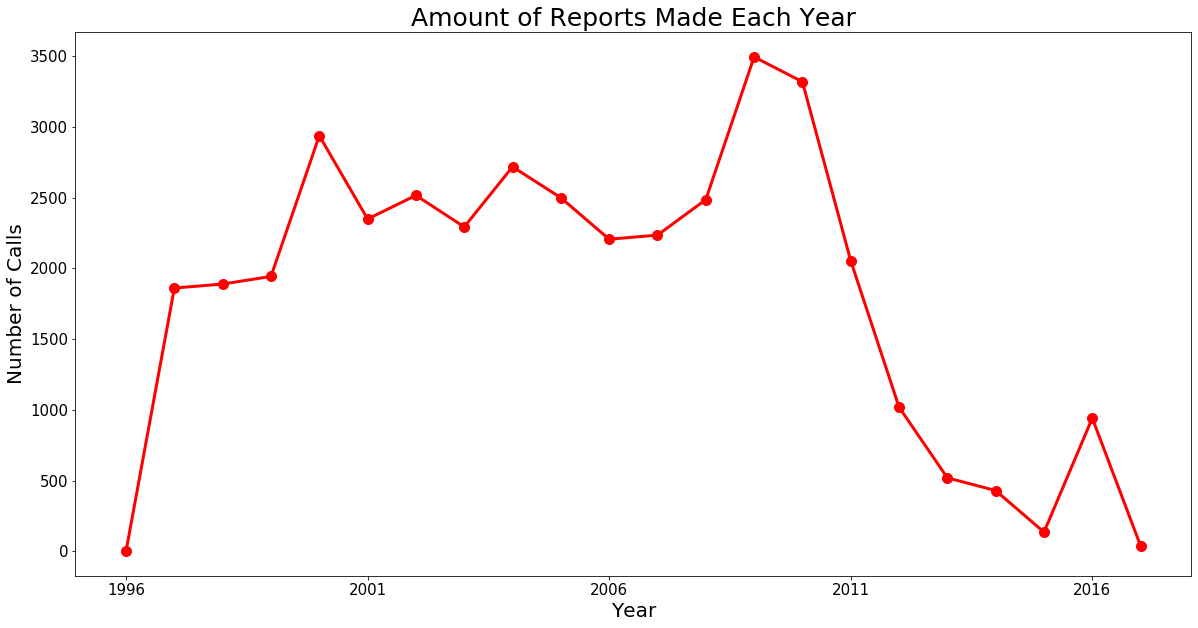

In [81]:
print((koala_data['Year'].value_counts(ascending=True)))
year_values=koala_data.groupby(['Year'])['Year'].count().plot(kind='line', linewidth=3, markersize=20, style='.-', fontsize=15, markevery=1, color = 'red')
plt.title("Amount of Reports Made Each Year", fontsize=25)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Number of Calls', fontsize=20)
plt.show()
# axis = koala_data.loc[range(1996,2017)]


Male       15396
Female     14479
Unknown     9048
Name: Adult Gender, dtype: int64


Text(0.5, 1.0, 'Koala Gender')

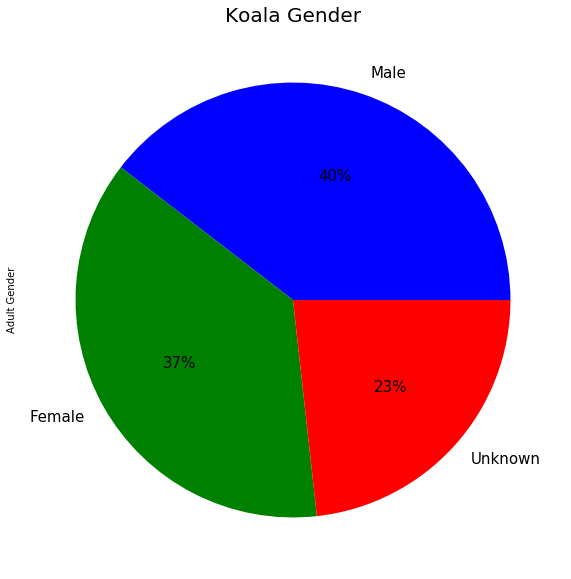

In [82]:
print(koala_data["Adult Gender"].value_counts())
koala_data["Adult Gender"].value_counts().plot(kind="pie", fontsize=15, autopct='%1.0f%%', colors=['Blue', 'Green', 'Red'])
plt.title("Koala Gender", fontsize=20)


Joyner               514
Kurwongbah           527
Redland Bay          534
Mount Forbes         559
Strathpine           620
Springwood           625
Narangba             629
Morayfield           648
Victoria Point       655
Burpengary           667
Sheldon              739
Wellington Point     774
Birkdale             897
Bray Park            916
Lawnton             1018
Thornlands          1052
Ormiston            1106
Alexandra Hills     1205
Cleveland           1522
Kallangur           1584
Petrie              2012
Capalaba            2334
Name: Koala Suburb, dtype: int64


Text(0, 0.5, 'Reports')

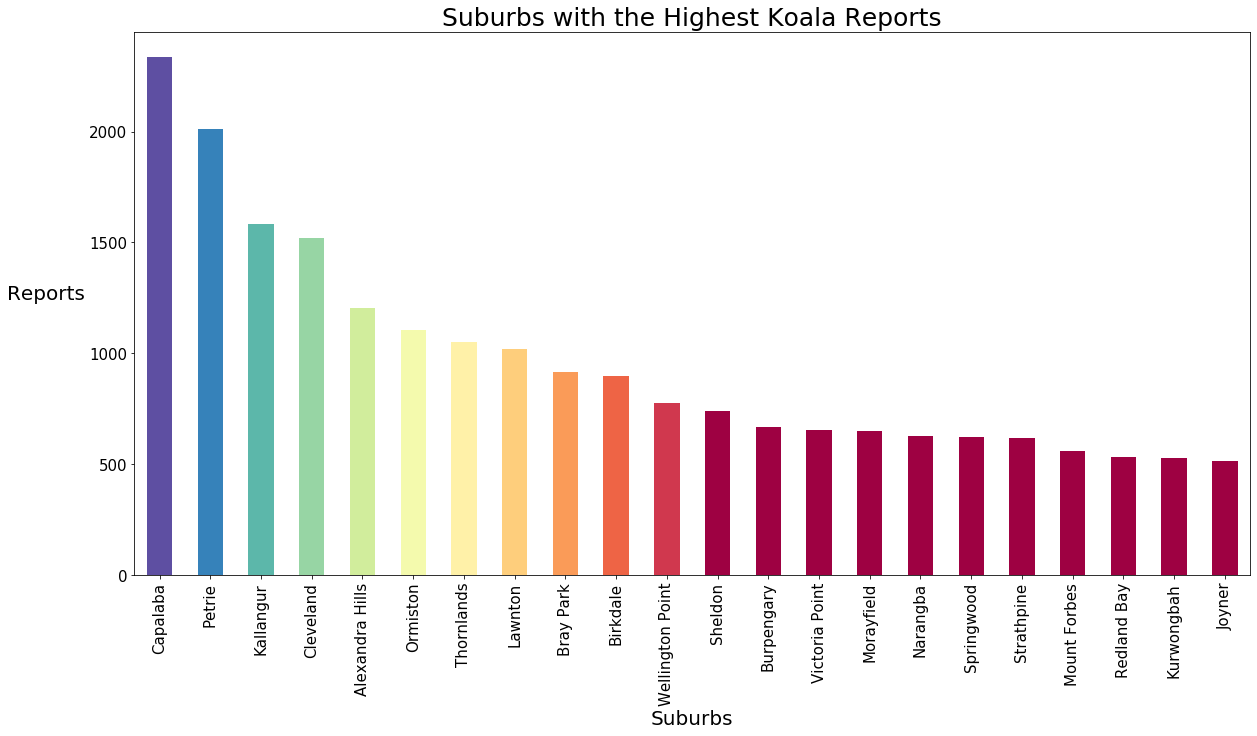

In [201]:
print(koala_data['Koala Suburb'].value_counts(ascending=True).loc[lambda x : x>500])
colors = plt.cm.Spectral_r(np.linspace(0, 2, 23))

koala_data["Koala Suburb"].value_counts(ascending=False).loc[lambda x : x>500].plot(kind="bar", fontsize=15, color=colors)
plt.title("Suburbs with the Highest Koala Reports", fontsize=25)
plt.xlabel('Suburbs', fontsize=20)
plt.ylabel('Reports', fontsize=20, rotation='horizontal', ha='right')


In [84]:
suburbs= QLD.loc[QLD['QLD_LOCA_2'].isin(['CAPALABA','PETRIE', 'JOYNER', 'KURWONGBAH', 'REDLAND BAY', 'MOUNT FORBES', 'STRATHPINE', 'SPRINGWOOD', 'NARANGBA', 'MORAYFIELD', 'VICTORIA POINT', 'BURPENGARY', 'SHELDON', 'WELLINGTON POINT', 'BIRKDALE', 'BRAY PARK', 'LAWNTON', 'THORNLANDS', 'ORMISTON', 'ALEXANDRA HILLS', 'CLEVELAND', 'KALLANGUR'])]
reports = [1018, 2012, 1584, 667, 916, 514, 1205, 620, 625, 629, 774, 2334, 1522, 1052, 534, 655, 897, 1106, 527, 739, 648, 559]
suburbs.insert(5, "Num_Reports", reports, True)
suburbs = suburbs.sort_values(by ='Num_Reports', ascending= False)
suburbs

,LC_PLY_PID,DT_CREATE,LOC_PID,QLD_LOCALI,QLD_LOCA_2,Num_Reports,geometry
2237,70000,2019-12-05,QLD530,2017-11-09,CAPALABA,2334,"POLYGON ((153.21498 -27.56850, 153.21321 -27.5..."
847,70284,2019-12-05,QLD2361,2018-02-05,PETRIE,2012,"POLYGON ((152.99122 -27.27840, 152.99044 -27.2..."
848,70255,2019-12-05,QLD1506,2018-05-09,KALLANGUR,1584,"POLYGON ((152.99785 -27.27075, 152.99632 -27.2..."
2238,70015,2019-12-05,QLD632,2018-02-05,CLEVELAND,1522,"POLYGON ((153.28494 -27.54972, 153.27912 -27.5..."
1118,66232,2017-12-12,QLD31,2018-02-05,ALEXANDRA HILLS,1205,"POLYGON ((153.23597 -27.56564, 153.23576 -27.5..."
2385,65778,2017-09-12,QLD2289,2017-11-09,ORMISTON,1106,"POLYGON ((153.26057 -27.52434, 153.26028 -27.5..."
2239,70363,2019-12-05,QLD2890,2017-11-09,THORNLANDS,1052,"POLYGON ((153.22875 -27.58999, 153.22875 -27.5..."
28,67865,2018-09-13,QLD1682,2017-11-09,LAWNTON,1018,"POLYGON ((152.98550 -27.29748, 152.98548 -27.2..."
1002,60029,2016-06-29,QLD368,2016-08-10,BRAY PARK,916,"POLYGON ((152.96487 -27.30461, 152.96461 -27.3..."
2269,65271,2017-09-12,QLD266,2017-11-09,BIRKDALE,897,"POLYGON ((153.22777 -27.51541, 153.22771 -27.5..."


Text(470.0170646132759, 0.5, 'Longitude')

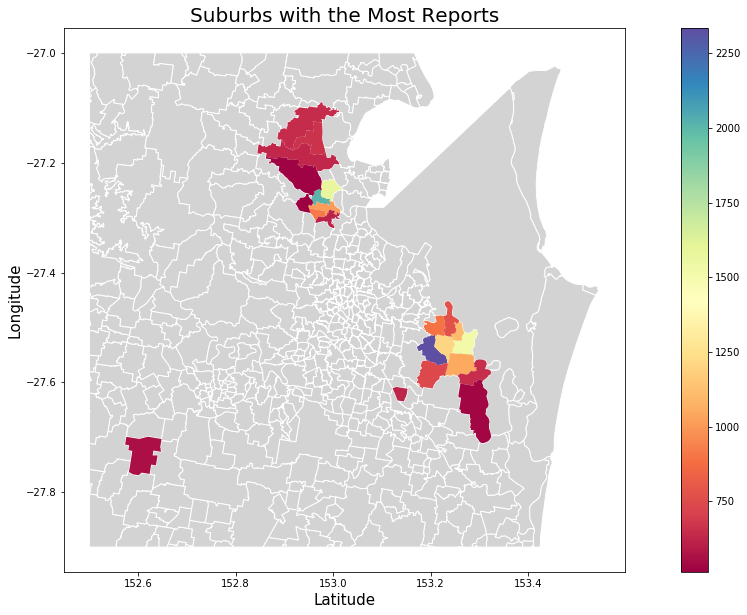

In [85]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

polygon = Polygon([(152.5, -27.9), (152.5, -27), (154, -27), (154, -27.9), (152.5, -27.9)])
poly_gdf = gp.GeoDataFrame([1], geometry=[polygon], crs=QLD.crs)

QLD_clipped = gp.clip(QLD, polygon)
QLD_clipped.plot(ax=ax, color = 'lightgrey',edgecolor='white')
suburbs.plot(ax=ax, column='Num_Reports', cmap='Spectral', legend=True)
ax.set_title("Suburbs with the Most Reports", fontsize=20)
plt.xlabel('Latitude', fontsize=15)
plt.ylabel('Longitude', fontsize=15)

In [86]:
monthcounts = koala_data["Month"].value_counts().reset_index().rename(columns = {'Month':'Count','index':'Month'})
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
mapping = {month: i for i, month in enumerate(months)}
key = monthcounts['Month'].map(mapping)
monthcounts = monthcounts.iloc[key.argsort()]
monthcounts.index = [0,1,2,3,4,5,6,7,8,9,10,11] 
monthcounts


,Month,Count
0,Jan,2712
1,Feb,2199
2,Mar,2097
3,Apr,2093
4,May,2456
5,Jun,2631
6,Jul,3690
7,Aug,4961
8,Sep,5306
9,Oct,5125


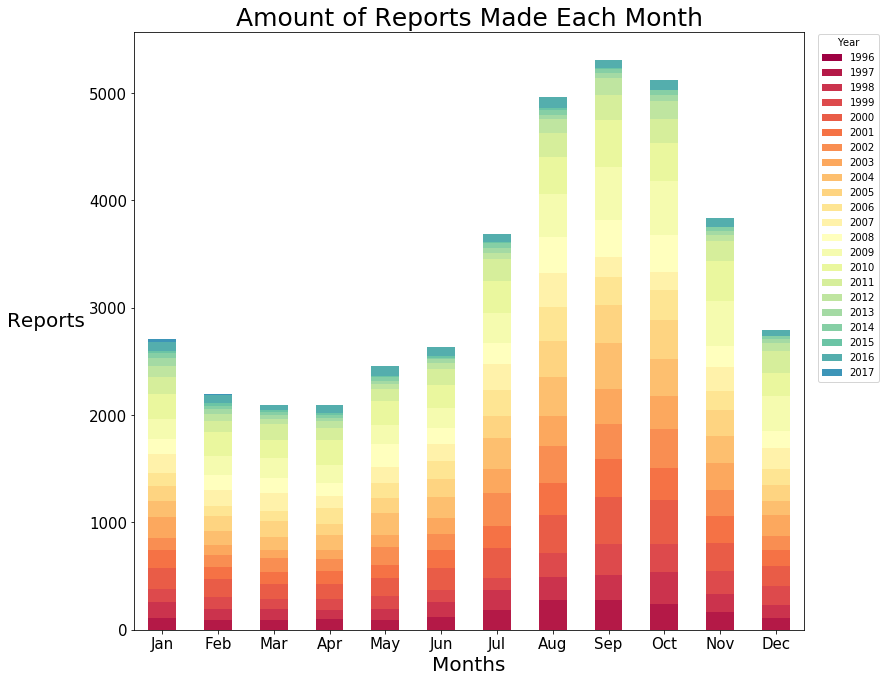

In [191]:
df= koala_data[['Year','Month']].dropna()

df['Counter'] =1 
Count = df.groupby(['Year','Month']).sum()#sum function
Count.reset_index(level=['Month','Year'])
data= Count.reset_index(level=['Month','Year'])

pivot_df = data.pivot(index='Month', columns='Year', values='Counter')
new_index = ['Jan','Feb', 'Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_yr = pivot_df.reindex(new_index)

colors = plt.cm.Spectral(np.linspace(0, 1, 25))


#Note: .loc[:,[1996','1997', '1998']] is used here to rearrange the layer ordering
month_yr.loc[:,['1996','1997', '1998','1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']].plot.bar(stacked=True,color=colors, figsize=(12,11), rot=0,fontsize=15)
plt.title("Amount of Reports Made Each Month", fontsize=25)
plt.xlabel('Months', fontsize=20)
plt.ylabel('Reports', fontsize=20, rotation='horizontal', ha='right')
plt.legend(loc='upper right', bbox_to_anchor=(1.12, 1.005),title="Year",fontsize='medium', fancybox=True)


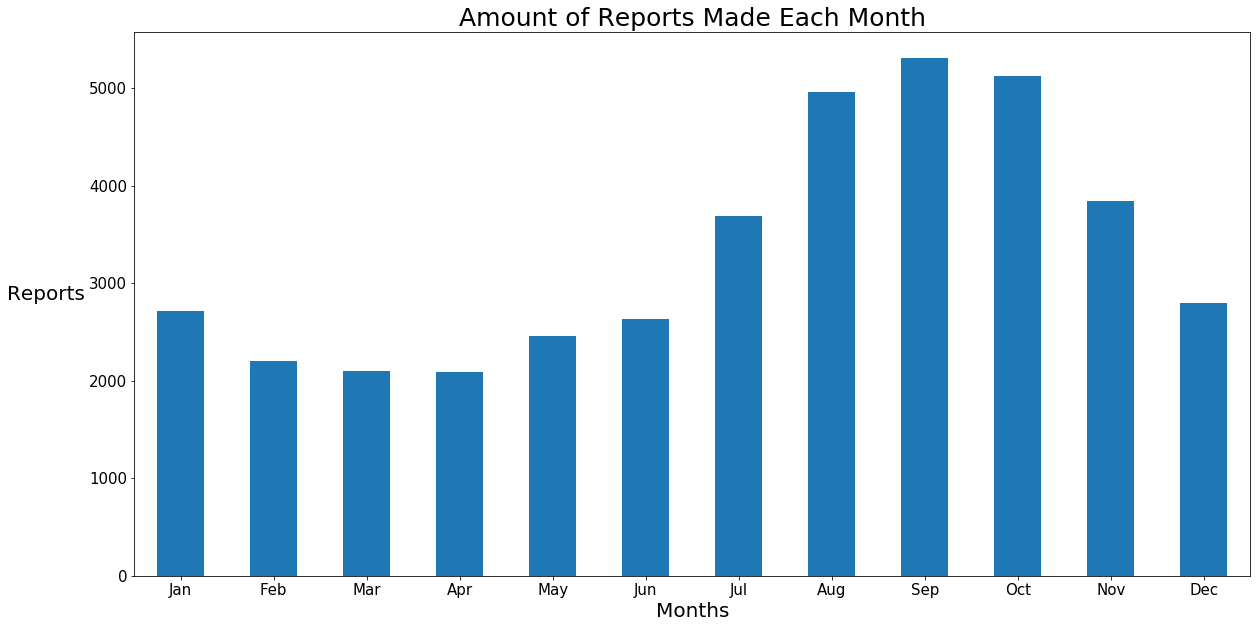

In [36]:
monthcounts.plot(kind='bar',x='Month',y='Count',fontsize=15, rot=0, legend=None)
plt.title("Amount of Reports Made Each Month", fontsize=25)
plt.xlabel('Months', fontsize=20)
plt.ylabel('Reports', fontsize=20, rotation='horizontal', ha='right')

plt.show()

In [54]:
df1 = pd.pivot_table(brand, values='Count', index='Parent Companies', columns='Month')
df1.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1.2, 1))
plt.xlabel('\n Parent Company', fontsize=15)
plt.ylabel('Quantity of Cars', fontsize=15, rotation='vertical', ha='right')
plt.title("Car Family Manufactures", fontsize=20 

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U4'), dtype('<U4')) -> dtype('<U4')

In tree         16669
On ground       11564
In captivity     3574
Other            2094
Name: Adult Situation, dtype: int64


Text(0, 0.5, 'Number of Koalas')

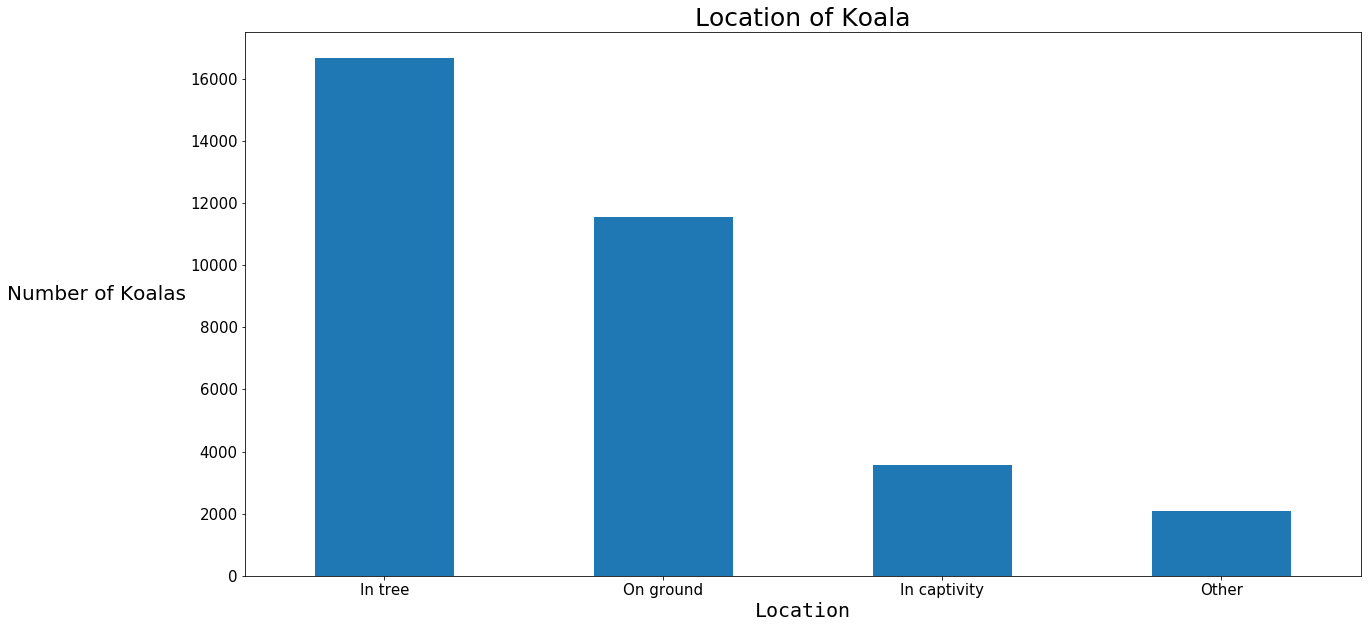

In [13]:
print(koala_data["Adult Situation"].value_counts())
koala_data["Adult Situation"].value_counts().plot(kind="bar", fontsize=15, rot=0)
plt.title("Location of Koala", fontsize=25)
plt.xlabel('Location', fontsize=20, family = 'monospace')
plt.ylabel('Number of Koalas', rotation='horizontal', ha='right', fontsize=20)



Doing the same thing on a dataframe gives us the whole column

In [71]:
name = koala_data["Animal Name"].value_counts()
top25= name[26:53]


top25[top25.name != 'DEAD AND DEAD']

top25

# .reset_index().rename(columns = {'Animal Name':'Count','index':'Name'})


HARRY            21
CHARLIE          19
GEORGE           19
BRUCE            18
KENNY            18
DEAD AND DEAD    18
ANDY             17
SAM              17
LUCY             17
FRED             17
REUNITED         16
MARY             16
MAGGIE           16
JOSH             16
DALE             16
DAISY            15
WENDY            15
ANGEL            15
ROSE             14
BELLA            14
CHLOE            14
RUBY             14
KATE             14
BEN              13
DEAD AND JOEY    13
JAMES            13
AMY              13
Name: Animal Name, dtype: int64

In [ ]:
koala_data["LONGITUDE"].plot()

If we do a simple `plot` on this column we get a pretty dense, but useless graph. It much better one would be a histogram.

In [ ]:
koala_data["LONGITUDE"].hist()

The problem we have now is that almost _all_ fines are less than $2000, but there's a very long tail that fills up the right of the graph.

Let's exclude all the values above $3000, and see what it looks like.

We can do that with a nice feature of pandas, boolean indexing:

In [ ]:
koala_data["LONGITUDE"][koala_data["LONGITUDE"] < 152].hist()

That's pretty crazy/powerful, so let's see that happen a bit more clearly.

We'll make our own series and call it  `some_numbers`

Let's give it the values 0-99 

In [ ]:
# Note the capital S, I have no idea why they did that!
# but if you get an `AttributeError: 'module' object has no attribute 'series'` error...
#                 v
some_numbers = pd.Series(range(100))
some_numbers.head()

We can use boolean indexing to get just the values that are less than 8

In [ ]:
some_numbers[some_numbers < 8]

Or we can be fancy and get the numbers that are less than 4 _or_ more than 97:

In [ ]:
some_numbers[(some_numbers < 4) | (some_numbers > 97)] #this needs the round brackets,
                                                       # not really sure why.

We can be _really fancy_ too!

This needs to resolve to a list of booleans that matches the list of inputs. It's filtering only for values that are True.

If we use a list comprehension then we can do almost anything we like!

In [ ]:
pets = ["Dog", "Goat", "pig", "Sheep", "Cattle", "Zebu", "Cat", "Chicken", "Guinea pig",         "Donkey", "duck", "Water buffalo", "Western honey bee", "dromedary camel", "Horse", 
        "silkmoth", "pigeon", "goose", "Yak", "Bactrian camel", "Llama", "Alpaca", "guineafowl",         "Ferret", "muscovy duck", "Barbary dove", "Bali cattle", "Gayal", "turkey", "Goldfish", 
        "rabbit", "Koi", "canary", "Society finch", "Fancy mouse", "Siamese fighting fish",         "Fancy rat and Lab rat", "mink", "red fox", "hedgehog", "Guppy"]

pets_series = pd.Series(pets)
pattern_of_bools = ["o" in x for x in pets_series]
print(pattern_of_bools)

pets_series[pattern_of_bools]

_Note: the first `in` means a different thing to the second `in`. I was wondering if I should leave this out, but it's probably good to expose you to strange stuff!_

Anyway, back to our fines, it looks like we have a similar pattern of fines here, lots at the bottom end, not so many high value ones. 

In [ ]:
koala_data["LONGITUDE"][koala_data["LONGITUDE"] < 152].hist()

Let's see what's under $1000

In [ ]:
koala_data["LONGITUDE"][koala_data["LONGITUDE"] < 150].hist()

This warants some further investigation, but we'll come back to it in a bit. First, let's look at some of the other columns.

In the `LEGISLATION` column it tells us which law was invoked to give this fine. 

In [ ]:
koala_data["Adult Size"].value_counts()

*ROAD RULES 2008* and *2014* are pretty popular, but only one person got a ticket under the *COMBAT SPORTS REGULATION 2014* and one other person got booked for something under the *TATTOO PARLOURS REGULATION 2013*

In [ ]:
koala_data["Adult Size"].value_counts().plot(kind="bar")

We're going to see this distribution over and over again as we look at all kinds of data set.

These are probably the most common distributions, but they leave off the [power law](https://en.wikipedia.org/wiki/Power_law), which I think this probably is. 
![](http://blog.cloudera.com/wp-content/uploads/2015/12/distribution.png)
[img](http://blog.cloudera.com/blog/2015/12/common-probability-distributions-the-data-scientists-crib-sheet/)

In [ ]:
pdvc = koala_data["Adult Size"].value_counts()
pdvc[pdvc < 10000].plot(kind="bar")

This pattern keeps repeating itself:

# Making plots nice

I said we'd come back to our histogram. [Here's a demo histogram from the matplotlib website](http://matplotlib.org/1.2.1/examples/pylab_examples/histogram_demo.html).

In [ ]:
# This bit makes some random data. Ignore it
mu, sigma = 100, 15; x = mu + sigma*np.random.randn(10000)

In [ ]:
# the histogram of the data
plt.hist(x, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$') # allows for latex formatting
# plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

In [ ]:
# the histogram of the data
plt.hist(x, 50, density=True, facecolor='green', alpha=0.75)
plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ IQ:}\ \mu=100,\ \sigma=15$') # allows for latex formatting
# plt.axis([40, 160, 0, 0.03])
plt.grid(True)
plt.show()

Here's how we made our histogram before:

Let's look at some of the things we can do to this. The docs for histograms are here: http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hist

We can go back to our initial, unfiltered, data:

In [ ]:
plt.hist(koala_data["LONGITUDE"], bins=50)
plt.show()

Instead of doing the filtering before we present the data, we can use the graph to hide the extents of an axis:

In [ ]:
plt.hist(koala_data["LONGITUDE"], bins=50, range=(151, 154))
plt.show()

We can nice that up a bit by pulling the parameters out as variables:
(unmagically, no difference!)

In [ ]:
number_of_bins = 50
lower_bound = 151
upper_bound = 154
plt.hist(koala_data["LONGITUDE"], bins=number_of_bins, range=(lower_bound, upper_bound))
plt.show()

This is still pretty naughty, we should have at least a title and some axis lables.

We do that by setting some more properties on the `plt` object:

In [ ]:
number_of_bins = 100
lower_bound = 151.5
upper_bound = 153.5

plt.hist(koala_data["LONGITUDE"], bins=number_of_bins, range=(lower_bound, upper_bound))
plt.title("Amount of Koala found in a certain longitude", fontsize=18)
plt.xlabel('LONGITUDE', fontsize=26)
plt.ylabel('AMOUNT', fontsize=26)
plt.grid(True)
plt.show()

In [ ]:
matplotlib.rcParams.update(saved_style_state) # revert to regular matplotlib styles, not xkcd

# some tricky tricks

Say you have a _lot_ of rows, running things on them takes a long time. You can test on a subset of that and then come bakc to the full dataframe once you are more sure that it works.

To do this we can use python slices in combination with the dataframe's `.loc` property.

Let's say you want to apply a function to each row in a dataframe, and save the result as a new column in the dataframe. This is where `apply` come in handy.